# Learn about the nitrogen cycling related KO patterns predicted by Metagenomic sequencing & Picrust2 predictions

## Background

In the LAMP soil project, we have 8 soil samples at different experimental conditions (such as fertilizer). Each of these 8 samples has both metagenomic sequencing and 16S rRNA sequencing data. For each soil sample, the nitrogen cycling gene KO abundance profiles (including 46 KEGG ortholog annotated nitrogen cycling genes) were generated using both metagenome sequencing analysis and PICRUST2 function prediction from 16S rRNA sequencing. 

Our goal is to find the patterns of nitrogen cycling gene abundances under different factors such as function inference methods (metagenome Vs. picrust2), fertilizer level (N0 Vs. N400), and so on. To achieve this goal, I plan to first standardize the nitrogen cycling gene abundance data separately for those resulted from metagenome sequencing and PICRUSt2. Then I will combine the standardized data from two function inference methods, and use PCA to understand the covariance structure of the data. 

## Data preprocessing

<br>

### Load in some basic packages:

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<br>

### Read in the data

Read in the nitrogen cycling functional gene abundance data generated from metagenome and picrust2 analysis:

In [239]:
metag_rel_abun = pd.read_csv('rel_abun_sort_filtered_metag_Nitro.csv',
                               index_col = 'ko_id')

picrust_rel_abun = pd.read_csv('rel_abun_sort_filtered_picrust2_Nitro.csv',
                                 index_col = 'ko_id')

We can see from the dataframes below that the 8 columns represents 8 soil samples, each row is a KEGG ortholog annotated nitrogen cycling functional gene:

In [240]:
print(f'Metagenome profile shape: {metag_rel_abun.shape}')
display(metag_rel_abun.head(3))
print(f'PICRUSt2 profile shape: {picrust_rel_abun.shape}')
display(picrust_rel_abun.head(3))

Metagenome profile shape: (46, 8)


,S2_2016_0,S2_2017_0,S5_2016_0,S5_2017_0,S2_2016_400,S2_2017_400,S5_2016_400,S5_2017_400
ko_id,,,,,,,,
K00260,0.000002,0.000004,0.000003,7.994800e-07,0.000002,0.000002,0.000002,0.000004
K00261,0.000531,0.000607,0.000545,6.004095e-04,0.000537,0.000566,0.000556,0.000613
K00262,0.000060,0.000097,0.000049,1.079298e-04,0.000064,0.000072,0.000064,0.000087


PICRUSt2 profile shape: (46, 8)


,S2_2016_0,S2_2017_0,S5_2016_0,S5_2017_0,S2_2016_400,S2_2017_400,S5_2016_400,S5_2017_400
ko_id,,,,,,,,
K00260,0.000082,0.000050,0.000071,0.000060,0.000064,0.000034,0.000078,0.000035
K00261,0.000676,0.000701,0.000653,0.000843,0.000746,0.000802,0.000744,0.000765
K00262,0.000177,0.000206,0.000195,0.000183,0.000175,0.000181,0.000173,0.000203


The two abundance profiles were generated by me and I am pretty sure there is no missing values. But just to be safe, let's still do a sanity check:

In [292]:
print(f'Total number of missing values in metagenome generated abundance profile: {metag_rel_abun.isnull().sum().sum()}')
print(f'Total number of missing values in picrust2 generated abundance profile: {picrust_rel_abun.isnull().sum().sum()}')

Total number of missing values in metagenome generated abundance profile: 0
Total number of missing values in picrust2 generated abundance profile: 0


<br>

For later standardization steps, we will also load and format the total number of gene counts of each sample generated from the two function inference methods (metagenome & picrust2):

In [252]:
# metagenome total counts
metag_N = pd.read_csv('abs_abun_metag_totalKO.csv')[['x']].T
metag_N.columns = metag_rel_abun.columns

# picrust2 total counts
picrust2_N = pd.read_csv('abs_abun_picrust2_totalKO.csv')[['x']].T
picrust2_N.columns = picrust_rel_abun.columns

The total counts data looks like:

In [293]:
print(f'For metagenome:')
metag_N

For metagenome:


,S2_2016_0,S2_2017_0,S5_2016_0,S5_2017_0,S2_2016_400,S2_2017_400,S5_2016_400,S5_2017_400
x,1083079,985577,1000741,1250813,1079858,1293712,1208050,998122


In [294]:
print(f'For PICRUSt2:')
picrust2_N

For PICRUSt2:


,S2_2016_0,S2_2017_0,S5_2016_0,S5_2017_0,S2_2016_400,S2_2017_400,S5_2016_400,S5_2017_400
x,8390751,8677866,8864552,8206746,8308235,8395907,8395729,8164569


<br>

### Data standardization

Although PCA does not require strict statistical assumptions, it is sensitive to the scale of different features. Let's check the largest possible ratio between feature variances if we just combine the raw abundance profile of metagenome and picrust2 together:

In [304]:
raw_combined = pd.concat([metag_rel_abun, picrust_rel_abun], axis = 1).T
raw_vars = raw_combined.cov().to_numpy().diagonal()

print(f'The largest ratio between two feature variances is: {raw_vars.max() / raw_vars.min()}')

The largest ratio between two feature variances is: 1171911.987183193


<br>

From the information above, we can tell that feature variances are at very different scales and a standardization is definitly neccesary. To avoid the different scales caused by function inference methods (metagenome Vs. picrust2) within each KO, I plan to standardize the metagenome and picrust2 generated profiles separately before combining them together. 

To do a z standardize at the multinomial proportional data for each sample, I assumed there is a standard deviation for each nitrogen KO $i$ in each sample: $\sigma_{\bar{x}} = \sqrt{\frac{p_i(1-p_i)}{N}}$ where $N$ is the total number of counts in each sample. Each value for each nitrogen KO in each sample is thus standardized through $p_{std} = \frac{p_i}{\sqrt{\frac{p_i(1-p_i)}{N}}}$. I did these with the code below: 

In [325]:
# Get the standard deviation matrix sigma
sigma_metag = np.multiply(metag_rel_abun, (1-metag_rel_abun)) \
    .div(metag_N.iloc[0], axis = 'columns') \
    .pow(1/2)

sigma_picrust = np.multiply(picrust_rel_abun, (1-picrust_rel_abun)) \
    .div(picrust2_N.iloc[0], axis = 'columns') \
    .pow(1/2)

# Standardize the relative abundance data, transpose and combine
std_metag_abun = metag_rel_abun.div(sigma_metag) \
    .T \
    .assign(method = 'metag')

std_picrust_abun = picrust_rel_abun.div(sigma_picrust) \
    .T \
    .assign(method = 'picrust2')

# Combine the two standardized matrices
std_combined_abun = pd.concat([std_metag_abun, std_picrust_abun])
std_combined_abun.head(3)

ko_id,K00260,K00261,K00262,K00265,K00266,K00284,K00360,K00362,K00363,K00366,...,K10945,K10946,K15371,K15576,K15577,K15578,K15579,K15864,K15876,method
S2_2016_0,1.414215,23.985525,8.062500,26.897638,23.628111,19.081991,1.414215,12.768106,8.124286,11.000615,...,6.324672,6.557569,28.768593,12.125179,10.050344,10.863372,1.000000,5.744650,7.416387,metag
S2_2017_0,2.000004,24.461461,9.798436,27.396554,22.276664,17.352001,1.414215,11.000675,7.810491,12.166439,...,5.656946,7.141613,26.954317,8.660584,6.855818,7.615997,NaN,2.645761,4.358941,metag
S5_2016_0,1.732053,23.351595,7.000171,25.523005,22.276579,19.238941,1.000000,11.917221,8.124306,9.487260,...,5.477308,6.164531,27.813622,11.917221,9.747257,9.165536,1.414215,6.164531,7.810488,metag


The sample names for Metagnome and its corresponding Picrust2 profiles are the same. To ensure the uniqueness of index in the dataframe, let's add a suffix to each index:

In [326]:
std_combined_abun.index = [f'{x}_{str(i)}' for i,x in enumerate(std_combined_abun.index)]

We will not use these for PCA, but I am adding some categorical factors (fertilizer, year, s_value, soil_sample) to the dataframe `std_combined_abun` as well:

In [327]:
std_combined_abun['fertilizer'] = ['N' + x.split('_')[2] for x in std_combined_abun.index]
std_combined_abun['year'] = [x.split('_')[1] for x in std_combined_abun.index]
std_combined_abun['s_value'] = [x.split('_')[0] for x in std_combined_abun.index]
std_combined_abun['soil_sample'] = [x.rsplit('_', 1)[0] for x in std_combined_abun.index]

<br>

Before moving to the next section, let's do a final missing value check since $NaN$ values may be generated due to $0$ count and $0$ in the sigma (denominator):

In [345]:
miss_df = std_combined_abun.isnull().sum().reset_index(name = 'count')
miss_df[miss_df['count']!=0]

,ko_id,count
30,K02588,1
34,K05601,4
35,K10535,1
43,K15579,9


Let's keep that in mind, and I will change all the $NaN$s to $0$ for now:

In [348]:
std_combined_abun.fillna(0, inplace=True)

<br>

## Modeling

Let's first extract the numerical abundance columns from the dataframe:

In [349]:
std_pca_df = std_combined_abun.loc[:, ~std_combined_abun.columns.isin(['method', 'fertilizer', 'year', 's_value', 'soil_sample'])]

### Select the number of factors to retain

#### Scree plot

We will first use Scree plot to visualize the proportion of variance explained by each principal component:

In [351]:
# Build and fit the PCA model
from sklearn.decomposition import PCA

pca_combined = PCA()
pca_com = pca_combined.fit(std_pca_df)
print(f'Number of total components: {pca_com.n_components_}')

Number of total components: 16


Text(0.5, 1.0, 'Scree plot')

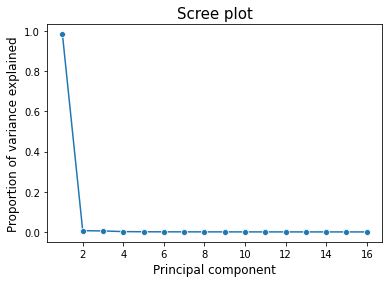

In [352]:
# Scree plot
PC_values = np.arange(pca_com.n_components_) + 1
sns.lineplot(x = PC_values, y = pca_com.explained_variance_ratio_, marker="o")
plt.xlabel("Principal component", fontsize= 12)
plt.ylabel("Proportion of variance explained", fontsize= 12)
plt.title("Scree plot", fontsize= 15)

The Scree plot shows that the first principal component can already explain at least $95\%$ of the total variances. The following components seem to contribute much less to the variances.

#### Cumulative variances

Another way to see the variances explained by principal components and decide the number of components to retain is through cumulative variances. 

By default, the `PCA()` function in `sklearn.decomposition` will keep all the components. The function below will take a dataframe for PCA and a cumulative variance threshold as inputs; build a default PCA model, iterature through the principal components and calculate the cumulative total variances explained by the iterated components until it reaches the input threshold; then fit a PCA model with the resulted number of PCs and transform the input data with this model:

In [375]:
def pca(df, cumsum_vari = 0.99):
    # Find out the number of PCs that can explain input cumulative variances
    pca = PCA()
    pca.fit(df)
    
    n_pc = 0
    total_vari = 0.0
    for p_var in pca.explained_variance_ratio_:
        if total_vari >= cumsum_vari:
            break
        else:
            total_vari += p_var
            n_pc += 1
            
    # Fit the PCA model with the resulted number of PCs and the input df
    pca_m = PCA(n_components=n_pc)
    pca_trans = pca_m.fit_transform(df) 
    cols = [f'principal_component_{i}' for i in range(1, n_pc+1)]
    
    pca_df = pd.DataFrame(data = pca_trans,
                          columns = cols,
                          index = df.index)
    print(f'{str(n_pc)} principal component(s) explained {str(total_vari)} amount of total variances.')
    return(pca_df)

Let's generate a transformed dataset with PCs that explain at least $0.99$ amount of the total variances:

In [380]:
std_pca_2pc = pca(std_pca_df)

# Add the categorical factors to the transformed data
cata_fac = std_combined_abun.loc[:, std_combined_abun.columns.isin(['method', 'fertilizer', 'year', 's_value', 'soil_sample'])]
std_pca2_full_df = pd.concat([std_pca_2pc, cata_fac], axis=1)
std_pca2_full_df

2 principal component(s) explained 0.991226909184879 amount of total variances.


,principal_component_1,principal_component_2,method,fertilizer,year,s_value,soil_sample
S2_2016_0_0,-135.291693,-1.020274,metag,N0,2016,S2,S2_2016_0
S2_2017_0_1,-139.582678,-0.699612,metag,N0,2017,S2,S2_2017_0
S5_2016_0_2,-139.677665,-1.348148,metag,N0,2016,S5,S5_2016_0
S5_2017_0_3,-128.950169,0.599393,metag,N0,2017,S5,S5_2017_0
S2_2016_400_4,-135.167465,0.776514,metag,N400,2016,S2,S2_2016_400
S2_2017_400_5,-127.970151,2.249371,metag,N400,2017,S2,S2_2017_400
S5_2016_400_6,-131.789203,-0.182241,metag,N400,2016,S5,S5_2016_400
S5_2017_400_7,-138.621403,-0.270013,metag,N400,2017,S5,S5_2017_400
S2_2016_0_8,137.512010,-2.268395,picrust2,N0,2016,S2,S2_2016_0
S2_2017_0_9,145.709591,-8.348882,picrust2,N0,2017,S2,S2_2017_0


<br>

### Visualize the principal components

Let's plot PC2 Vs. PC1 using color to differentiate levels in different categorical groups:

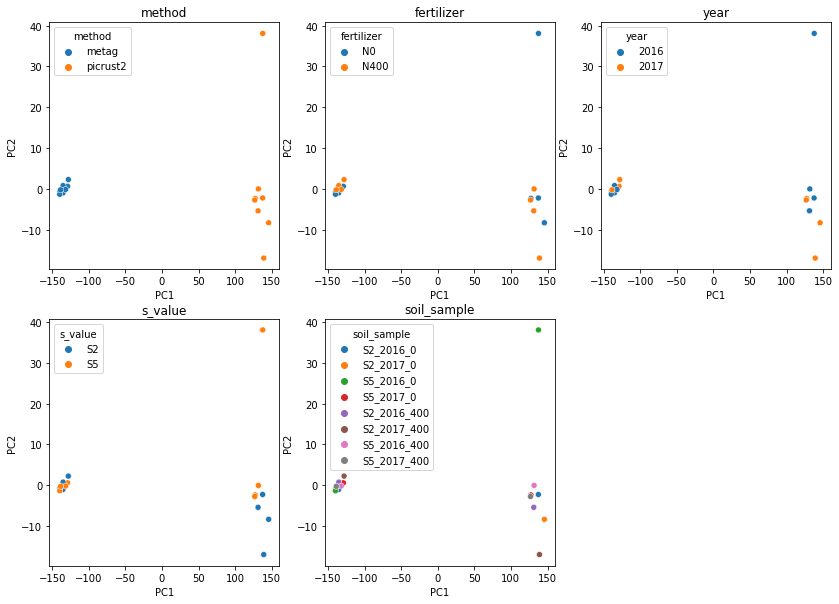

In [379]:
cata = cata_fac.columns.to_list()

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (14, 10))

for i in cata:
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    sns.scatterplot(data=std_pca2_full_df, x = "principal_component_1", y = "principal_component_2", hue=i)
    c += 1
plt.show()

From the first subplot reflecting method factor with colors, we can tell that PC1 gives a good separation of metagenome and picrust2. From the transformed principal component 1 values above, we can also see that the principal component 1 is actually a linear combination with large positive coefficients for profiles generated by PICRUSt2 and large negative coefficients for profiles generated by Metagenome. 

While we cannot see obvious patterns for other categorical factors in the rest plots. That also makes sense since pincipal component 1 itself explains $0.98489$ amount of the total variances.